# Определение токсичных комментариев / Toxic comments detection

Магазин товаров попросил нас построить модель машинного обучения для поиска токсичных комментариев. Качество модели по метрике *F1* должно быть не меньше 0.75.

----

A store asked us to build a machine learning model to find toxic comments. The quality of the model by the metric *F1* must be at least 0.75.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import string
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import emoji
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
import requests
from pathlib import Path
import ast
import torch
import transformers
from tqdm import tqdm
from collections import Counter
import io
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
%matplotlib inline
nltk.download('popular', quiet=True)
import pickle

## Загрузка данных / Data import

In [3]:
try:
    comments = pd.read_csv('toxic_comments.csv')
except:
    comments = pd.read_csv('/datasets/toxic_comments.csv')

In [5]:
comments.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
comments.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 81.1 MB


Проверим соотношение классов целевого признака.

Target variable classes ratio.

Доля каждого из классов в датасете


0    0.898388
1    0.101612
Name: toxic, dtype: float64

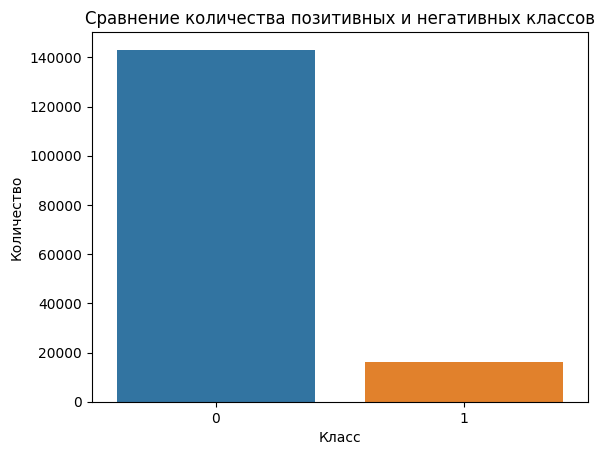

In [7]:
sb.countplot(x='toxic', data=comments)
plt.title('Сравнение количества позитивных и негативных классов')
plt.xlabel('Класс')
plt.ylabel('Количество');

print('Доля каждого из классов в датасете')
comments['toxic'].value_counts(normalize=True)

In [8]:
# создадим корпус комментариев с которым дальше будем работать / 
# create a comment corpus with which we will work further
corpus = comments['text'].to_list()
corpus[:11]

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
 '"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on r

Данные содержат колонку с комментариями и колонку с их категорией (1 - токсичный комментарий, 0 - нетоксичный комментарий). В данных 159571 наблюдений, пропусков нет. В целевой переменной наблюдается крупный дисбаланс классов: нетоксичных комментариев почти в 9 раз больше, чем токсичных. Будем учитывать это при построении модели классификации.

Далее, очистим и приведем текстовые данные к стандартному виду.

-----

The data contains a column with comments and a column with their category (1 - toxic comment, 0 - non-toxic comment). There are no missing values in the data of 159571 observations. There is a large class imbalance in the target variable: there are almost 9 times more non-toxic comments than toxic ones. We will take this into account when constructing a classification model.

Next, we clean up and bring the text data to the standard form.

## Подготовка и изучение данных / Data preparation and EDA

Подготовка текстовых данных - очень специфический процесс. Какие-то этапы можно применить к любым текстовым данным, некоторые - не ко всем. Предобработка обычно состоит из токенизации (разбивка на более мелкие части - в нашем случае слова), лемматизации (приведение слов к словарной форме), стандартных операций (удаление пунктуации, стоп-слов, сссылок, приведение к общему регистру), перевод эмотиконов и смайликов в слова. Данные этапы могут идти не в таком порядке, в котором мы их перечислили. Всё зависит от цели и данных. В нашем случае обработка будет идти в следующем порядке:

- приведение к нижнему регистру, удаление стоп-слов, ссылок, html-тэгов и т.д.
- перевод сленговых сокращений в полную форму, 
- перевод смайликов и эмотиконов в текст
- удаление пунктуации, небуквенных символов, цифр, и не латинских букв,
- лемматизация.

-----

Preparing text data is a very specific process. Some steps can be applied to any text data, some - not to all. Preprocessing usually consists of tokenization (breaking down into smaller parts - in our case, words), lemmatization (reducing words to dictionary form), standard operations (removing punctuation, stop words, links, reducing to a common case), translating emoticons and emoticons into words. These steps may not be in the order in which we listed them. It all depends on the purpose and data. In our case, the processing will go in the following order:

- reduction to lowercase, removal of stop words, links, html tags, etc.
- translation of slang abbreviations into full form,
- translate emoticons and emoticons into text
- removal of punctuation, non-alphabetic characters, numbers, and non-Latin letters,
- lemmatization.

### Приведение к нижнему регистру, удаление, стоп-слов, ссылок, html-тэгов, приведение сокращений в полную форму и т.д. / Transform to lower case, removal of stop words, links, html tags, abbreviations to a full form, etc.

In [9]:
# напишем функцию, которая будет проходить по корпусу
# и выполнять необходимый процессинг комментариев / function for preprocessing

def text_pre_clean(text, stop_words, url_pattern, html_pattern, contr_map):

  # к нижнему регистру
  clean_text = text.lower()

  # приведение сокращений в полную форму
  clean_text = ' '.join([word.replace(word, CONTRACTION_MAP[word]) if word in CONTRACTION_MAP else word for word in clean_text.split()])

  #удаление стоп-слов (с токинизацией)
  clean_text = " ".join([word for word in str(clean_text).split() if word not in stop_words])

  #удаление ссылок
  clean_text = url_pattern.sub(r'', clean_text)

  #удаление html-тагов
  clean_text = html_pattern.sub(r'', clean_text)

  # удаление пробелов с краев текста
  clean_text = clean_text.strip()
  
  #удаление лишних пробелов внутри текста
  clean_text = re.sub(r' +', ' ', clean_text)

  #удаление названия картинок (*jpg, *.jpeg)
  clean_text = re.sub(r'.*.(jpg|jpeg|gif|png|svg)', '', clean_text)

  return clean_text

In [10]:
# применим функцию / apply preprocrssing function
STOPWORDS = set(stopwords.words('english'))
url_pattern = re.compile(r'https?://\S+|www\.\S+')
html_pattern = re.compile('<.*?>')
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "can not",
"can't've": "can not have",
"'cause": "because",
"could've": "could have",
"couldn't've": "couldn't have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"mightn't've": "mightn't have",
"must've": "must have",
"mustn't've": "mustn't have",
"needn't've": "needn't have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"sha'n't": "shall not",
"shan't've": "shan't have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't've": "shouldn't have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
}


corpus_pre_cleaned = [text_pre_clean(comm, STOPWORDS, url_pattern, html_pattern, CONTRACTION_MAP) for comm in corpus]

corpus_pre_cleaned[:11]

['explanation edits made username hardcore metallica fan reverted? vandalisms, closure gas voted new york dolls fac. please remove template talk page since retired now.89.205.38.27',
 "d'aww! matches background colour seemingly stuck with. thanks. (talk) 21:51, january 11, 2016 (utc)",
 'hey man, really trying edit war. guy constantly removing relevant information talking edits instead talk page. seems care formatting actual info.',
 '" make real suggestions improvement - wondered section statistics later on, subsection ""types accidents"" -i think references may need tidying exact format ie date format etc. later on, no-one else first - preferences formatting style references want please let know. appears backlog articles review guess may delay reviewer turns up. listed relevant form eg wikipedia:good_article_nominations#transport "',
 'you, sir, hero. chance remember page on?',
 '" congratulations well, use tools well. · talk "',
 'cocksucker piss around work',
 'vandalism matt shirv

### Перевод сленговых слов в полную форму / Transfer slang to a full form

Но сначала подсчитаем их для статистики и графиков.

First, calculate slang words for statistics and plots.

In [11]:
# возьмём данные из ссылки и считаем их в датафрэйм / get the data from the link and import it to dataframe
slang_df = pd.read_csv('https://raw.githubusercontent.com/rishabhverma17/sms_slang_translator/master/slang.txt', sep="=", header=None)
slang_df.columns = ['abbrv', 'description']
slang_df.set_index('abbrv', inplace=True)

slang_dict = slang_df['description'].to_dict()
slang_dict

# некоторые полезные нам слова написаны не в той форме, исправим это / some of words are in the wrong form
slang_dict['PITA'] = 'Pain In The Ass'
slang_dict['ROTFLMAO'] = 'Rolling On The Floor Laughing My Ass Off'
slang_dict['WTF'] = 'What The Fuck'
slang_dict['LMAO'] = 'Laugh My Ass Off'

slang_dict

{'AFAIK': 'As Far As I Know',
 'AFK': 'Away From Keyboard',
 'ASAP': 'As Soon As Possible',
 'ATK': 'At The Keyboard',
 'ATM': 'At The Moment',
 'A3': 'Anytime, Anywhere, Anyplace',
 'BAK': 'Back At Keyboard',
 'BBL': 'Be Back Later',
 'BBS': 'Be Back Soon',
 'BFN': 'Bye For Now',
 'B4N': 'Bye For Now',
 'BRB': 'Be Right Back',
 'BRT': 'Be Right There',
 'BTW': 'By The Way',
 'B4': 'Before',
 'CU': 'See You',
 'CUL8R': 'See You Later',
 'CYA': 'See You',
 'FAQ': 'Frequently Asked Questions',
 'FC': 'Fingers Crossed',
 'FWIW': "For What It's Worth",
 'FYI': 'For Your Information',
 'GAL': 'Get A Life',
 'GG': 'Good Game',
 'GN': 'Good Night',
 'GMTA': 'Great Minds Think Alike',
 'GR8': 'Great!',
 'G9': 'Genius',
 'IC': 'I See',
 'ICQ': 'I Seek you (also a chat program)',
 'ILU': 'ILU: I Love You',
 'IMHO': 'In My Honest/Humble Opinion',
 'IMO': 'In My Opinion',
 'IOW': 'In Other Words',
 'IRL': 'In Real Life',
 'KISS': 'Keep It Simple, Stupid',
 'LDR': 'Long Distance Relationship',
 'LM

In [12]:
slang_count = {}

for sl in slang_dict.keys():
  total_sum = sum([sum([comm.count(sl.lower()) for comm in list.split()]) for list in corpus_pre_cleaned])
  slang_count[sl] = total_sum

slang_count

{'AFAIK': 58,
 'AFK': 36,
 'ASAP': 123,
 'ATK': 69,
 'ATM': 1033,
 'A3': 176,
 'BAK': 438,
 'BBL': 437,
 'BBS': 68,
 'BFN': 0,
 'B4N': 0,
 'BRB': 6,
 'BRT': 5,
 'BTW': 940,
 'B4': 74,
 'CU': 56934,
 'CUL8R': 0,
 'CYA': 34,
 'FAQ': 194,
 'FC': 2056,
 'FWIW': 77,
 'FYI': 1232,
 'GAL': 3884,
 'GG': 22213,
 'GN': 20845,
 'GMTA': 0,
 'GR8': 6,
 'G9': 9,
 'IC': 249227,
 'ICQ': 21,
 'ILU': 507,
 'IMHO': 191,
 'IMO': 1235,
 'IOW': 81,
 'IRL': 2347,
 'KISS': 259,
 'LDR': 1281,
 'LMAO': 209,
 'LOL': 3226,
 'LTNS': 0,
 'L8R': 2,
 'MTE': 44,
 'M8': 50,
 'NRN': 7,
 'OIC': 1686,
 'PITA': 1475,
 'PRT': 38,
 'PRW': 4,
 'QPSA?\tQue Pasa?': 0,
 'ROFL': 56,
 'ROFLOL': 1,
 'ROTFLMAO': 2,
 'SK8': 2,
 'STATS': 255,
 'ASL': 175,
 'THX': 121,
 'TTFN': 13,
 'TTYL': 4,
 'U': 1047220,
 'U2': 48,
 'U4E': 0,
 'WB': 808,
 'WTF': 215,
 'WTG': 6,
 'WUF': 1,
 'W8': 6,
 '7K': 13}

In [13]:
total_slang = sum(slang_count.values())
print('Общее количество сленговых слов в комментариях:', total_slang)

Общее количество сленговых слов в комментариях: 1421783


/opt/anaconda3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


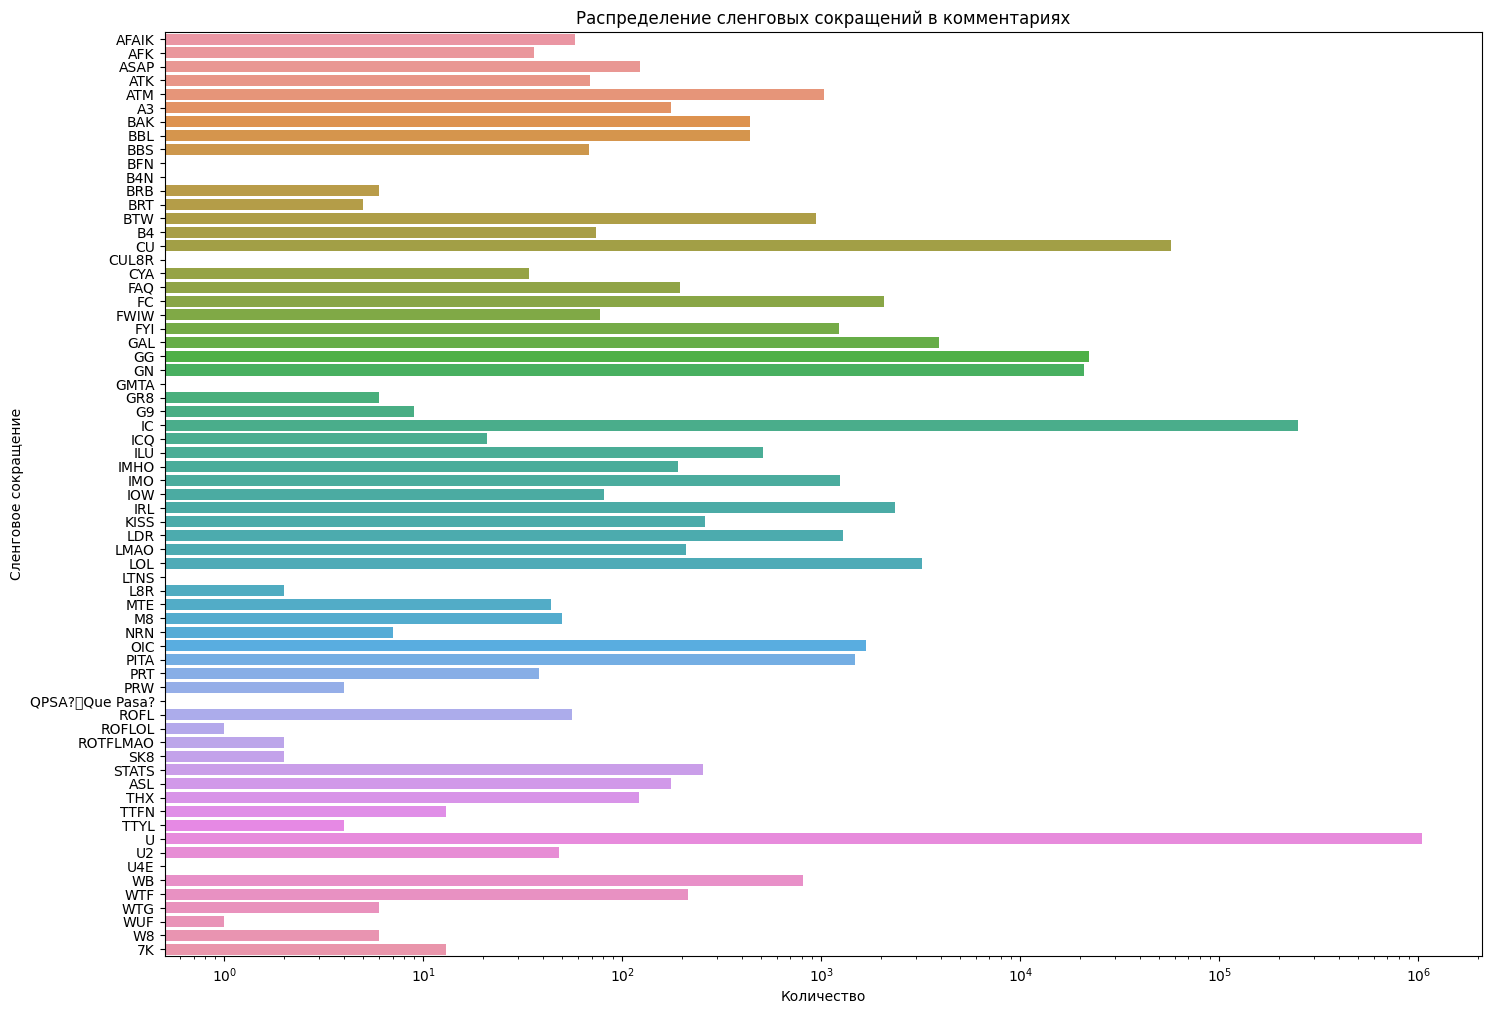

In [14]:
#посмотрим на распределение слэнгов / slang distribution

x = list(slang_count.keys())
y = list(slang_count.values())

plt.figure(figsize=(17,12))
sb.barplot(x=y, y=x)
plt.xscale('log')
plt.title('Распределение сленговых сокращений в комментариях')
plt.xlabel('Количество')
plt.ylabel('Сленговое сокращение');

График показывает, что сленговых выражений в комментариях довольно много. Переведем их в полную форму, чтобы модель учитывала их при определении эмоциональной окраски текста.

----

The plot shows that there are quite a lot of slang expressions in the comments. Let's translate them into a full form so that the model takes them into account when determining the toxicity of the text.

In [15]:
#напишем функцию для изменения сленговых выражений на их полный вариант / 
# function to transfer slang to a full form
def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in slang_dict.keys():
            new_text.append(slang_dict[w.upper()].lower())
        else:
            new_text.append(w)
    return " ".join(new_text)

In [16]:
# применим функцию chat_word_conversion
# apply chat_word_conversion

corpus_cleaned = [chat_words_conversion(comm) for comm in corpus_pre_cleaned]
corpus_cleaned[:11]

['explanation edits made username hardcore metallica fan reverted? vandalisms, closure gas voted new york dolls fac. please remove template talk page since retired now.89.205.38.27',
 "d'aww! matches background colour seemingly stuck with. thanks. (talk) 21:51, january 11, 2016 (utc)",
 'hey man, really trying edit war. guy constantly removing relevant information talking edits instead talk page. seems care formatting actual info.',
 '" make real suggestions improvement - wondered section statistics later on, subsection ""types accidents"" -i think references may need tidying exact format ie date format etc. later on, no-one else first - preferences formatting style references want please let know. appears backlog articles review guess may delay reviewer turns up. listed relevant form eg wikipedia:good_article_nominations#transport "',
 'you, sir, hero. chance remember page on?',
 '" congratulations well, use tools well. · talk "',
 'cocksucker piss around work',
 'vandalism matt shirv

### Перевод смайликов и эмотиконов в текст / Transfer of emojies and emoticons into a text form

Проверим наличие эмотиконов в тексте. Их можно перевести в текст, что может быть полезно для модели. Спасибо https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py за словарь эмотиконов.

----

Let's check the presence of emoticons in the text. They can be translated into text, which can be useful for the model. Thanks to https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py for the emoticon dictionary.

Также сначала найдем распределение эмотиконов и смайликов.

Also let's check the distribution of emojies and emoticons.

In [17]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [18]:
# проверим каждый комментарий на наличие эмотиконов и подсчитаем их общее количество
# check every comment for emoticons and calculate their total number
emoticons_count = {}

for emo in EMOTICONS.keys():
  total_sum = sum([sum([comm.count(emo) for comm in list.split()]) for list in corpus_cleaned])
  emoticons_count[emo] = total_sum

emoticons_count

{':‑\\)': 0,
 ':\\)': 0,
 ':-\\]': 0,
 ':\\]': 0,
 ':-3': 1,
 ':3': 1763,
 ':->': 0,
 ':>': 3,
 '8-\\)': 0,
 ':o\\)': 0,
 ':-\\}': 0,
 ':\\}': 0,
 ':-\\)': 0,
 ':c\\)': 0,
 ':\\^\\)': 0,
 '=\\]': 0,
 '=\\)': 0,
 ':‑D': 0,
 ':D': 0,
 '8‑D': 0,
 '8D': 0,
 'X‑D': 0,
 'XD': 0,
 '=D': 0,
 '=3': 43,
 'B\\^D': 0,
 ':-\\)\\)': 0,
 ':‑\\(': 0,
 ':-\\(': 0,
 ':\\(': 0,
 ':‑c': 0,
 ':c': 2559,
 ':‑<': 0,
 ':<': 2,
 ':‑\\[': 0,
 ':\\[': 0,
 ':-\\|\\|': 0,
 '>:\\[': 0,
 ':\\{': 0,
 ':@': 16,
 '>:\\(': 0,
 ":'‑\\(": 0,
 ":'\\(": 0,
 ":'‑\\)": 0,
 ":'\\)": 0,
 "D‑':": 0,
 'D:<': 0,
 'D:': 0,
 'D8': 0,
 'D;': 0,
 'D=': 0,
 'DX': 0,
 ':‑O': 0,
 ':O': 0,
 ':‑o': 0,
 ':o': 744,
 ':-0': 1,
 '8‑0': 0,
 '>:O': 0,
 ':-\\*': 0,
 ':\\*': 0,
 ':X': 0,
 ';‑\\)': 0,
 ';\\)': 0,
 '\\*-\\)': 0,
 '\\*\\)': 0,
 ';‑\\]': 0,
 ';\\]': 0,
 ';\\^\\)': 0,
 ':‑,': 0,
 ';D': 0,
 ':‑P': 0,
 ':P': 0,
 'X‑P': 0,
 'XP': 0,
 ':‑Þ': 0,
 ':Þ': 0,
 ':b': 1504,
 'd:': 1863,
 '=p': 114,
 '>:P': 0,
 ':‑/': 0,
 ':/': 46,
 ':-[.]': 0,
 '

In [19]:
total_emoticons = sum(emoticons_count.values())
print('Общее количество эмотиконов:', total_emoticons)

Общее количество эмотиконов: 10400


In [20]:
# датафрэйм с результатами подсчета эмотиконов / df with emoticons calculation
emoticons_count_df = pd.DataFrame(list(emoticons_count.items()), index=EMOTICONS.values()).reset_index()
emoticons_count_df.columns = ['emoticon_text', 'emoticon', 'count']
emoticons_count_df

,emoticon_text,emoticon,count
0,Happy face or smiley,:‑\),0
1,Happy face or smiley,:\),0
2,Happy face or smiley,:-\],0
3,Happy face or smiley,:\],0
4,Happy face smiley,:-3,1
...,...,...,...
214,Surpised,o\.O,0
215,Surprised,\(o\.o\),0
216,Surprised,oO,0
217,Dissatisfied,\(\*￣m￣\),0


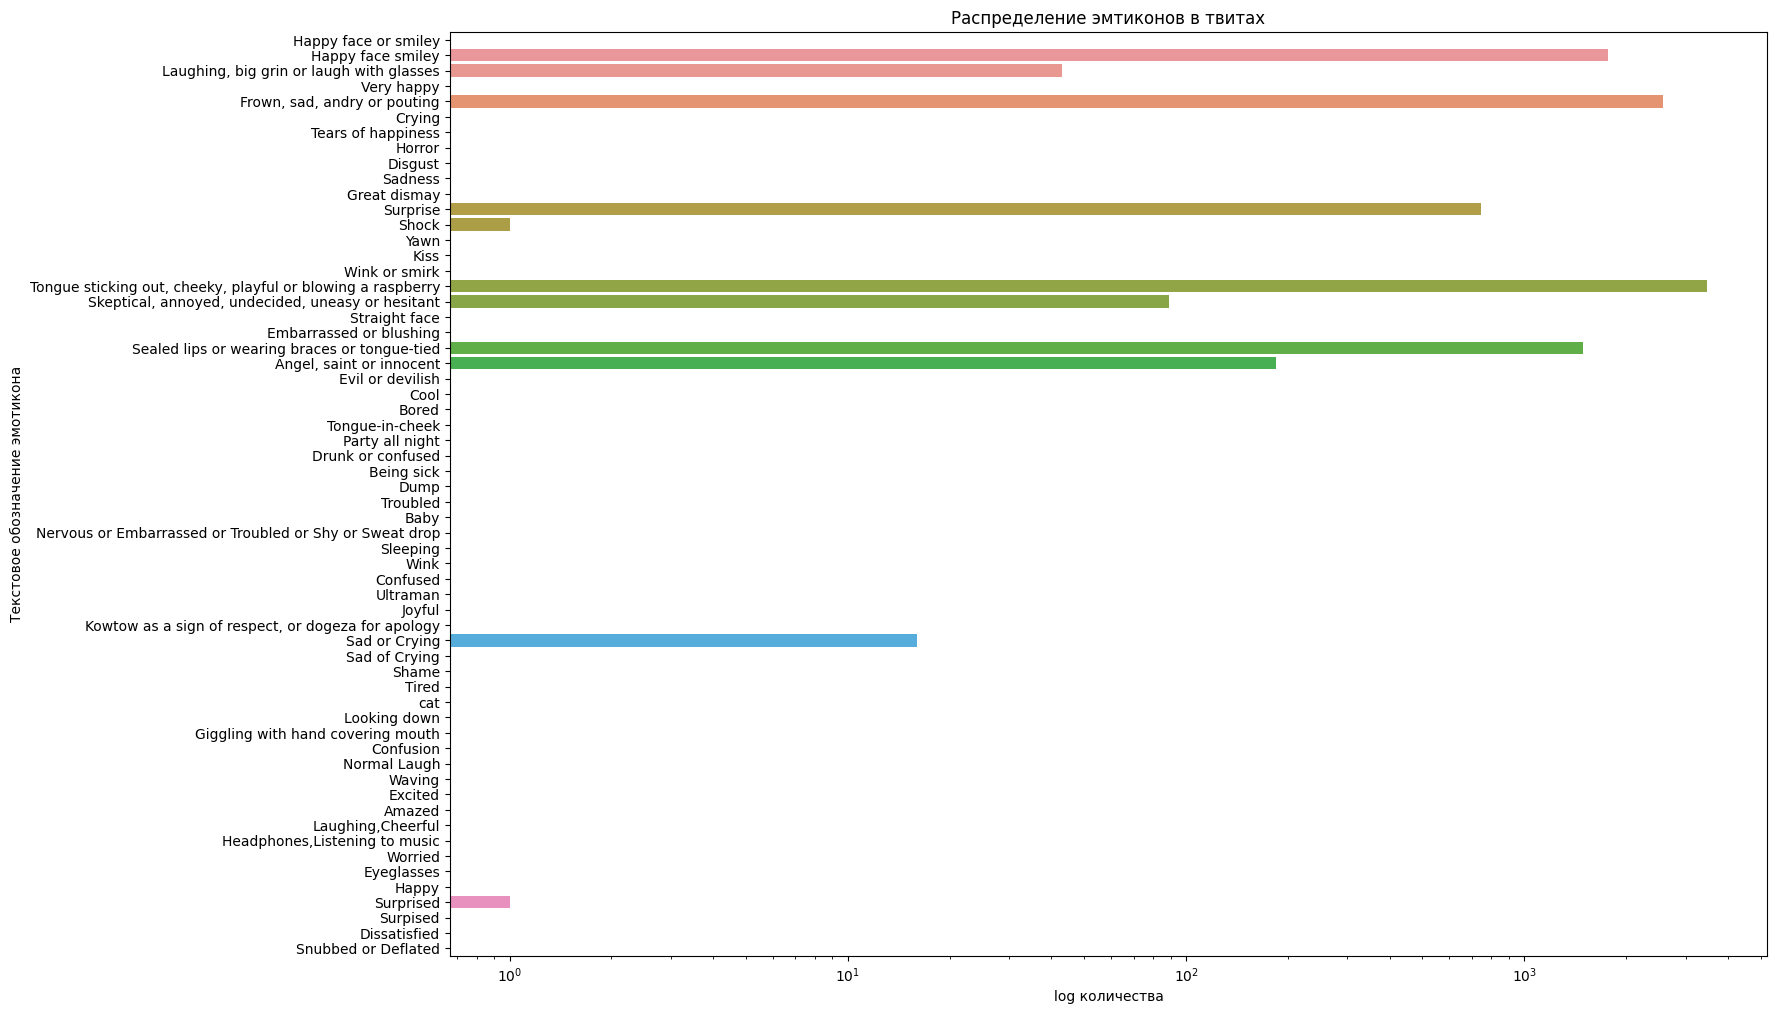

In [21]:
# распределение эмотиконов / emoticons distribution
plt.figure(figsize=(17,12))
sb.barplot(x='count', y='emoticon_text', data=emoticons_count_df, estimator=sum, ci=None)
plt.xscale('log')
plt.title('Распределение эмтиконов в твитах')
plt.xlabel('log количества')
plt.ylabel('Текстовое обозначение эмотикона');

Первую позицию занимают эмотиконы с высунутым языком (показывает насмешливое отношение к собеседнику).

На втором месте по количеству идут эмотиконы, выражающие злость, грусть, неодобрение.

На третьем месте - улыбающиеся, счастливые эмотиконы.

Эмотиконы имеют разную окраску, и, возможно, они могут отражать токсичность комментария. Их можно использовать в дальнейшем.

----

The first position is occupied by emoticons with their tongue hanging out (shows a mocking attitude towards the interlocutor).

In the second place are emoticons expressing anger, sadness, disapproval.

In the third place are smiling, happy emoticons.

Emoticons have different colors, and perhaps they can reflect the toxicity of the comment. They can be used later.

Теперь подсчитаем смайлики.

Count emojies.

С помощью библиотеки **emoji** проверим наличие смайликов в тексте. Их также можно будет превратить в текст.

Using the **emoji** library, we will check for the presence of emojies in the text. They can also be turned into text.

In [22]:
# проверим каждый комментарий на наличие смайликов и подсчитаем их количество
# check every comment for emojies and count their total number

emojies_count = {}

for emoj in emoji.UNICODE_EMOJI['en'].keys():
  total_sum = sum([sum([comm.count(emoj) for comm in list.split()]) for list in corpus_cleaned])
  emojies_count[emoj] = total_sum

In [23]:
total_emojies = sum(emojies_count.values())
print('Общее количество смайликов:', total_emojies)

Общее количество смайликов: 1859


In [24]:
# датафрэйм с результатами подсчета смайликов / df with emojies count
emojies_count_df = pd.DataFrame(list(emojies_count.items()))
emojies_count_df.columns = ['emoji', 'count']
emojies_count_df = emojies_count_df.query('count != 0').reset_index(drop=True) # удалим смайлы, которых нет в твитах
emojies_count_df

,emoji,count
0,♑,1
1,🎄,3
2,🗽,3
3,✈,14
4,🍌,7
...,...,...
63,▫,2
64,😉,16
65,😜,16
66,✍,49


In [47]:
# прочтём словарь из файла / import a dictionary from a file
with open('/Users/vlad/Documents/Documents Linux/Yandex DS/Projects/YandexPracticum-projects/cmmnts_classif/Emoji_Dict.p', 'rb') as fp:
    EMO_UNICODE = pickle.load(fp)

UNICODE_EMO = {v: k for k, v in EMO_UNICODE.items()}

In [48]:
# функция для перевода смайликов в текст / function for emojies transformation into a text
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = re.sub(r'('+emot+')', "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()), text)
    return text.lower()

In [49]:
emojies_text = pd.Series([convert_emojis(emo) for emo in emojies_count_df['emoji']])

In [50]:
emojies_count_df['emojies_text'] = emojies_text
emojies_count_df

,emoji,count,emojies_text
0,♑,1,capricorn
1,🎄,3,christmas_tree
2,🗽,3,statue_of_liberty
3,✈,14,airplane
4,🍌,7,banana
...,...,...,...
63,▫,2,white_small_square
64,😉,16,winking_face
65,😜,16,face_with_stuck-out_tongue_&_winking_eye
66,✍,49,writing_hand


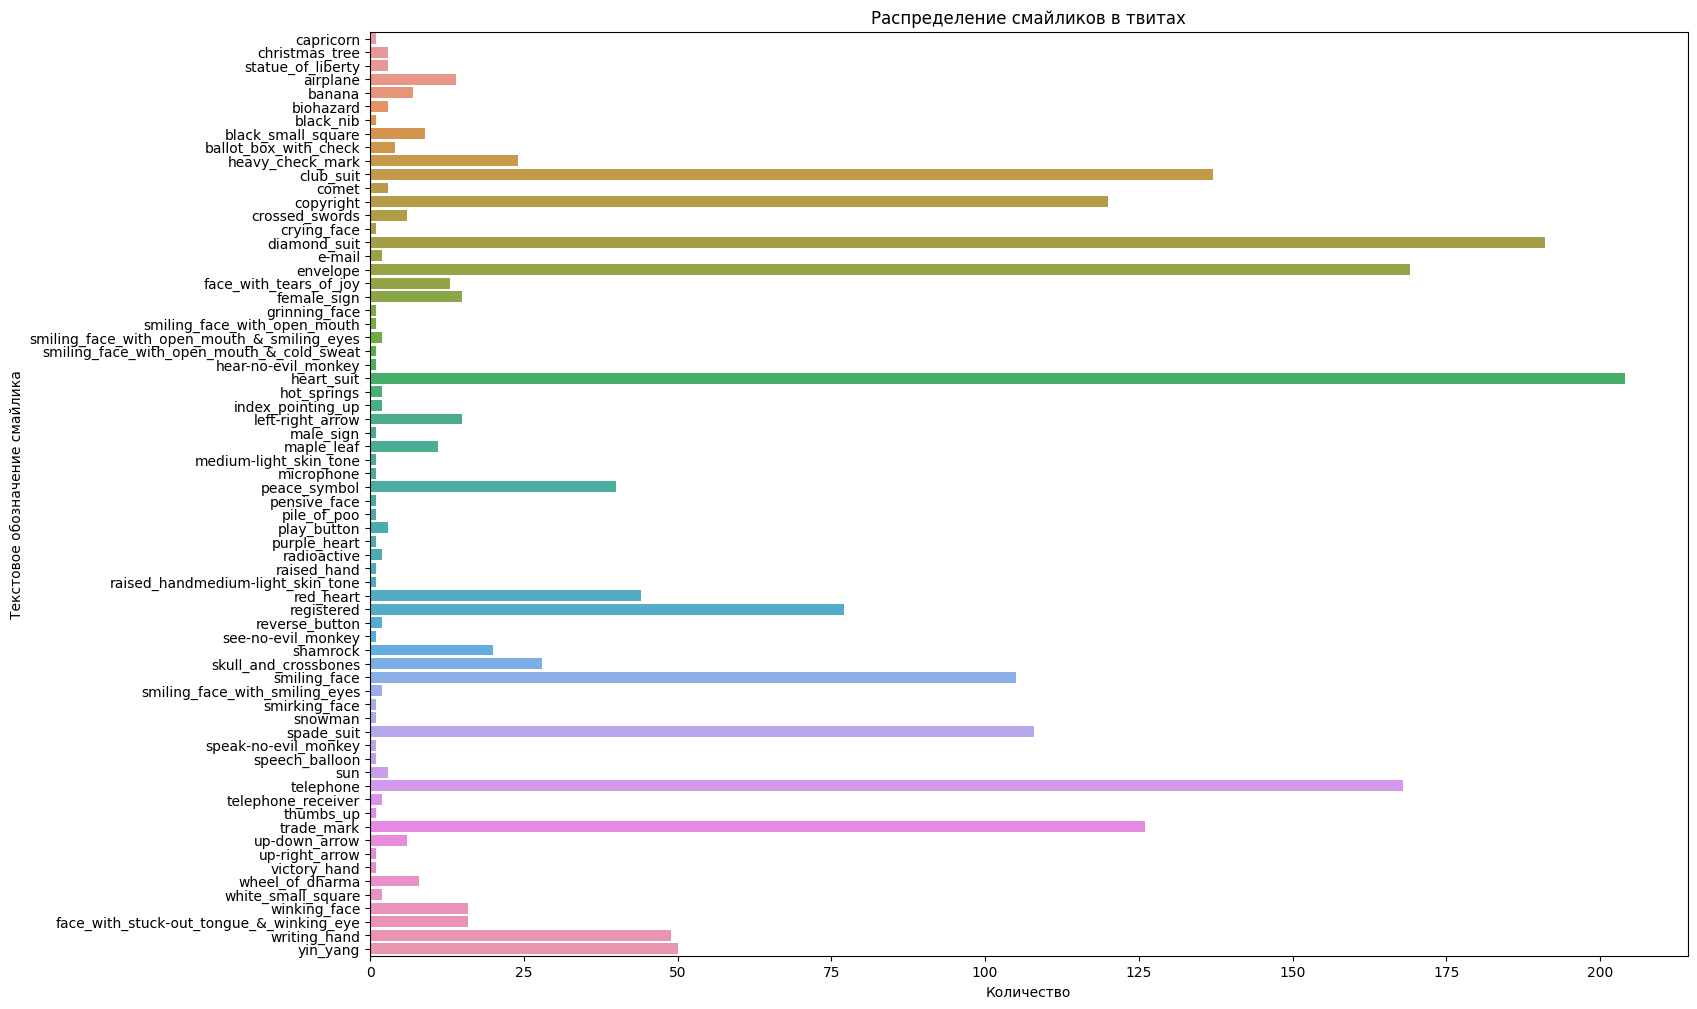

In [51]:
# распределение смайликов / emojies distribution
plt.figure(figsize=(17,12))
sb.barplot(x='count', y='emojies_text', data=emojies_count_df, estimator=sum, ci=None)
plt.title('Распределение смайликов в твитах')
plt.xlabel('Количество')
plt.ylabel('Текстовое обозначение смайлика');

На первом месте идет смайлик сердца. Возможно, это не токсичные комментарии.

На втором месте - масть бубны. Не знаю, что она могла бы означать.

На третьем месте конверт.

В целом, из графика видно, что есть целая палитра смайлов, которая могла бы описать окраску твита.

-----

In the first place is a heart emoticon. Perhaps these are not toxic comments.

In the second place is the suit of diamonds. I don't know what it could mean.

In the third place is the envelope.

In general, it can be seen from the graph that there is a whole palette of emojis that could describe the color of a tweet.

Теперь переведем смайлы и эмотиконы в текст.

Transfer emoticons and emojies to a text.

In [52]:
# функцию для перевода смайлов в текст мы написали, теперь напишем для эмотиконов
# this function is for emoticons transfer
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text.lower()

In [53]:
# применим функцию convert_emoticons
# apply convert_emoticons function

corpus_cleaned = [convert_emoticons(comm) for comm in corpus_cleaned]
corpus_cleaned[:11]

['explanation edits made username hardcore metallica fan reverted? vandalisms, closure gas voted new york dolls fac. please remove template talk page since retired now.89.205.38.27',
 "d'aww! matches background colour seemingly stuck with. thanks. (talkconfusion 21:51, january 11, 2016 (utcconfusion",
 'hey man, really trying edit war. guy constantly removing relevant information talking edits instead talk page. seems care formatting actual info.',
 '" make real suggestions improvement - wondered section statistics later on, subsection ""types accidents"" -i think references may need tidying exact format ie date format etc. later on, no-one else first - preferences formatting style references want please let know. appears backlog articles review guess may delay reviewer turns up. listed relevant form eg wikipedia:good_article_nominations#transport "',
 'you, sir, hero. chance remember page on?',
 '" congratulations well, use tools well. · talk "',
 'cocksucker piss around work',
 'vand

In [54]:
# применим функцию convert_emojis
# apply convert_emojies function

corpus_cleaned = [convert_emojis(comm) for comm in corpus_cleaned]
corpus_cleaned[:11]

['explanation edits made username hardcore metallica fan reverted? vandalisms, closure gas voted new york dolls fac. please remove template talk page since retired now.89.205.38.27',
 "d'aww! matches background colour seemingly stuck with. thanks. (talkconfusion 21:51, january 11, 2016 (utcconfusion",
 'hey man, really trying edit war. guy constantly removing relevant information talking edits instead talk page. seems care formatting actual info.',
 '" make real suggestions improvement - wondered section statistics later on, subsection ""types accidents"" -i think references may need tidying exact format ie date format etc. later on, no-one else first - preferences formatting style references want please let know. appears backlog articles review guess may delay reviewer turns up. listed relevant form eg wikipedia:good_article_nominations#transport "',
 'you, sir, hero. chance remember page on?',
 '" congratulations well, use tools well. · talk "',
 'cocksucker piss around work',
 'vand

### Удаление пунктуации, специальных символов, и цифр / Removal of punctuation, special characters and digits

In [55]:
# напишем функцию для удаления пунктуации
# function for punctuation removal
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [56]:
corpus_cleaned = [remove_punctuation(comm) for comm in corpus_cleaned]
corpus_cleaned[:11]

['explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired now892053827',
 'daww matches background colour seemingly stuck with thanks talkconfusion 2151 january 11 2016 utcconfusion',
 'hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info',
 ' make real suggestions improvement  wondered section statistics later on subsection types accidents i think references may need tidying exact format ie date format etc later on noone else first  preferences formatting style references want please let know appears backlog articles review guess may delay reviewer turns up listed relevant form eg wikipediagoodarticlenominationstransport ',
 'you sir hero chance remember page on',
 ' congratulations well use tools well · talk ',
 'cocksucker piss around work',
 'vandalism matt shirvington article reverted please 

Видно, что ещё остались пробелы в начале и конце строк. Удалим их.

There are trailing spaces left. Let's delete them.

In [57]:
corpus_cleaned = [comm.strip() for comm in corpus_cleaned]
corpus_cleaned[:11]

['explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired now892053827',
 'daww matches background colour seemingly stuck with thanks talkconfusion 2151 january 11 2016 utcconfusion',
 'hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info',
 'make real suggestions improvement  wondered section statistics later on subsection types accidents i think references may need tidying exact format ie date format etc later on noone else first  preferences formatting style references want please let know appears backlog articles review guess may delay reviewer turns up listed relevant form eg wikipediagoodarticlenominationstransport',
 'you sir hero chance remember page on',
 'congratulations well use tools well · talk',
 'cocksucker piss around work',
 'vandalism matt shirvington article reverted please agai

In [58]:
# напишем функцию для удаления символов и цифр, также удалим не латинские буквы
# function for characters and digits removal, removal of non-latin letters
def not_alpha_not_eng_remove(text):
  tokens = word_tokenize(text)
  clean_list = [token for token in tokens if token.isalpha() if token.isascii()]
  clean_str = ' '.join(clean_list)
  return clean_str

In [59]:
corpus_cleaned = [not_alpha_not_eng_remove(comm) for comm in corpus_cleaned]
corpus_cleaned[:11]

['explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired',
 'daww matches background colour seemingly stuck with thanks talkconfusion january utcconfusion',
 'hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info',
 'make real suggestions improvement wondered section statistics later on subsection types accidents i think references may need tidying exact format ie date format etc later on noone else first preferences formatting style references want please let know appears backlog articles review guess may delay reviewer turns up listed relevant form eg wikipediagoodarticlenominationstransport',
 'you sir hero chance remember page on',
 'congratulations well use tools well talk',
 'cocksucker piss around work',
 'vandalism matt shirvington article reverted please again banned',
 'sorry word nonsen

### Лемматизация / Lemmatization

Лемматизацию помогла сделать эта [статья](https://www.kaggle.com/code/sudalairajkumar/getting-started-with-text-preprocessing/notebook#Introduction).

[Reference article](https://www.kaggle.com/code/sudalairajkumar/getting-started-with-text-preprocessing/notebook#Introduction) for lemmatization

In [60]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}

# функция для лемматизации, учитывая часть речи
# function for lemmatization accounting for grammatical category
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [61]:
corpus_cleaned = [lemmatize_words(comm) for comm in corpus_cleaned]
corpus_cleaned[:11]

['explanation edits make username hardcore metallica fan revert vandalisms closure gas vote new york doll fac please remove template talk page since retire',
 'daww match background colour seemingly stick with thanks talkconfusion january utcconfusion',
 'hey man really try edit war guy constantly remove relevant information talk edits instead talk page seem care format actual info',
 'make real suggestion improvement wonder section statistic later on subsection type accident i think reference may need tidy exact format ie date format etc later on noone else first preference format style reference want please let know appear backlog article review guess may delay reviewer turn up listed relevant form eg wikipediagoodarticlenominationstransport',
 'you sir hero chance remember page on',
 'congratulation well use tool well talk',
 'cocksucker piss around work',
 'vandalism matt shirvington article revert please again ban',
 'sorry word nonsense offensive you anyway intend write anything 

Поскольку выполнение некоторых ячеек с кодом занимает много времени, на этом этапе сохраним очищенный корпус в **csv** файл. Для дальнейшей работы будем подгружать его из локальной папки.

-----

Since some cells with code take a long time to execute, at this stage we will save the cleaned body into a **csv** file. For further work, we will load it from a local folder.

In [62]:
corpus_cleaned_df = pd.DataFrame(corpus_cleaned, columns=["clean_text"])
corpus_cleaned_df.to_csv('corpus_cleaned_07_04_2023.csv', index=False)

In [4]:
downloads_path = str(Path.home() / "Downloads")

try:
    corpus_cleaned = pd.read_csv('corpus_cleaned_07_04_2023.csv')
except:
    corpus_cleaned = pd.read_csv(downloads_path+'/'+'corpus_cleaned_07_04_2023.csv')

corpus_cleaned_out = corpus_cleaned['clean_text'].astype('U').to_list()
corpus_cleaned_out[:11]

['explanation edits make username hardcore metallica fan revert vandalisms closure gas vote new york doll fac please remove template talk page since retire',
 'daww match background colour seemingly stick with thanks talkconfusion january utcconfusion',
 'hey man really try edit war guy constantly remove relevant information talk edits instead talk page seem care format actual info',
 'make real suggestion improvement wonder section statistic later on subsection type accident i think reference may need tidy exact format ie date format etc later on noone else first preference format style reference want please let know appear backlog article review guess may delay reviewer turn up listed relevant form eg wikipediagoodarticlenominationstransport',
 'you sir hero chance remember page on',
 'congratulation well use tool well talk',
 'cocksucker piss around work',
 'vandalism matt shirvington article revert please again ban',
 'sorry word nonsense offensive you anyway intend write anything 

Мы получили очищенный корпус твитов. Можно переходить к исследовательскому анализу данных.

We've got a cleaned up corpus of tweets. We can move on to exploratory data analysis.

## Исследовательский анализ данных / EDA

In [5]:
# токенизируем твиты / tweets tokenization
corpus_cleaned_out_tokenized = [word_tokenize(comm) for comm in corpus_cleaned_out]
corpus_cleaned_out_tokenized[0]

['explanation',
 'edits',
 'make',
 'username',
 'hardcore',
 'metallica',
 'fan',
 'revert',
 'vandalisms',
 'closure',
 'gas',
 'vote',
 'new',
 'york',
 'doll',
 'fac',
 'please',
 'remove',
 'template',
 'talk',
 'page',
 'since',
 'retire']

In [6]:
# переведем токены комментариев в один лист / transfer tokens to a list
all_tokens = []

for token_list in corpus_cleaned_out_tokenized:
    for token in token_list:
        all_tokens.append(token)

print('Длина списка всех токенов:', len(all_tokens))

Длина списка всех токенов: 5481696


Найдем 100 самых распространенных слов.

The top 100 used words.

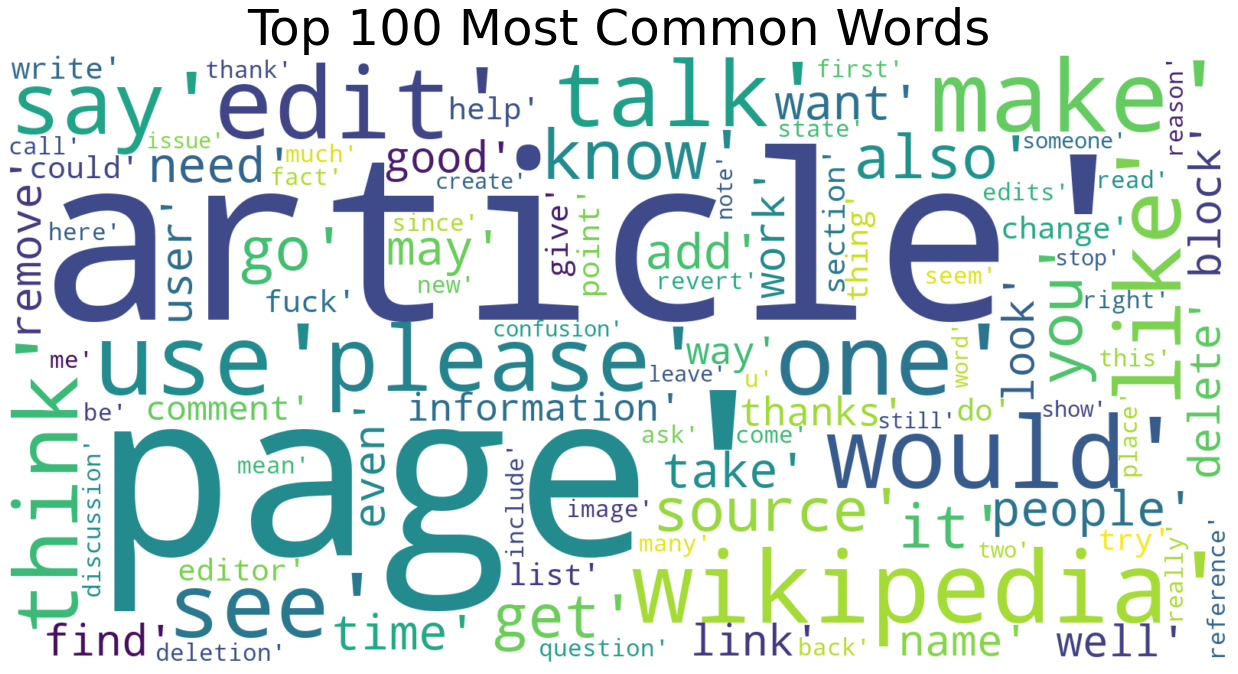

In [7]:
mostcommon_100 = FreqDist(all_tokens).most_common(100)

wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon_100))
fig = plt.figure(figsize=(17,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

Судя по 100 самым распространенным словам, в комментариях идут споры. Слово **article** является самым распространенным. Возможно, в ходе спора люди аргументируют свою позицию, приводя ссылку на какие-нибудь статьи. Самое интересное, что слово **fuck** также входит в наш ТОП-100. Есть слово **block**. Люди же могут комментировать отзывы других, и, возможно так они помечают комментарии, которые надо заблокировать/удалить.

Интересно как будет выглядеть распределение слов в разбивке по нашей целевой переменной. То есть какие слова чаще будут встречаться в токсичных и нетоксичных комментариях.

-----

From the 100 most common words, there are disputes in the comments. The word **article** is the most common. Perhaps, during the dispute, people argue their position by citing links to some articles. The most interesting thing is that the word **fuck** is also in our TOP-100. There is a word **block**. People can also comment on other people's reviews, and perhaps this is how they mark comments that need to be blocked/deleted.

I wonder what the distribution of words will look like, broken down by our target variable. That is, which words will be more common in toxic and non-toxic comments.

In [8]:
# добавим к корпусу комментариев целевую переменную
# add target variable to the comments corpus
clean_comments = pd.DataFrame({'comment': corpus_cleaned_out,
'toxic': comments['toxic']})

clean_comments

,comment,toxic
0,explanation edits make username hardcore metal...,0
1,daww match background colour seemingly stick w...,0
2,hey man really try edit war guy constantly rem...,0
3,make real suggestion improvement wonder sectio...,0
4,you sir hero chance remember page on,0
...,...,...
159287,and second time ask view completely contradict...,0
159288,ashamed horrible thing put talk page,0
159289,spitzer umm there actual article prostitution ...,0
159290,look like actually put speedy first version de...,0


In [9]:
# разобьем на токсичные и нетоксичные комментарии
# split to toxic and. non-toxic comments
clean_comments_toxic = clean_comments.query('toxic == 1')
clean_comments_non_toxic = clean_comments.query('toxic == 0')

print(clean_comments_toxic['toxic'].unique())
print(clean_comments_non_toxic['toxic'].unique())

[1]
[0]


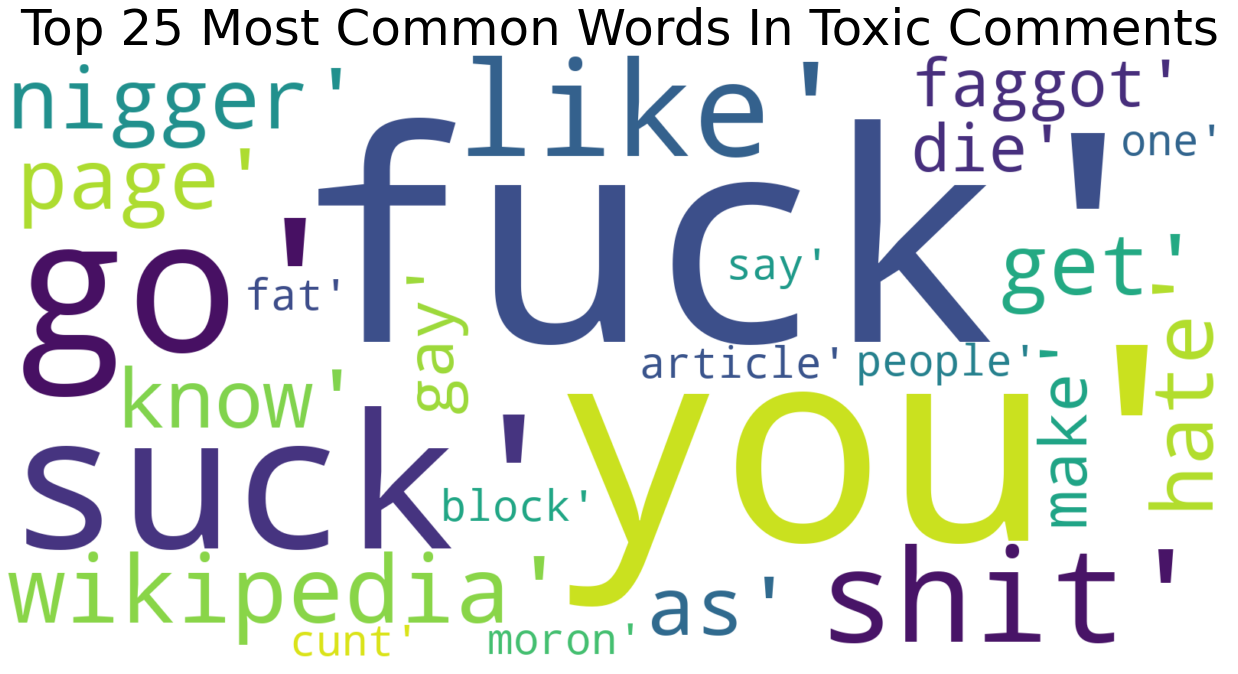

In [10]:
# посчитаем 25 самых распространенных слов для токсичных комментариев
# calculate top 25 words for TOXIC comments

toxic_comm_list = clean_comments_toxic['comment'].astype('U').to_list()

# токенезируем токсичные твиты / tokenize toxic comments
clean_comments_toxic_tokenized = [word_tokenize(comm) for comm in toxic_comm_list]

# переведем токены токсичных комментариев в один лист / transfer comments to a one list
all_tokens_toxic = []

for token_list in clean_comments_toxic_tokenized:
    [all_tokens_toxic.append(token) for token in token_list]

mostcommon_25_toxic = FreqDist(all_tokens_toxic).most_common(25)

wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon_25_toxic))
fig = plt.figure(figsize=(17,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 25 Most Common Words In Toxic Comments', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

Я думаю, нашей модели будет очень легко :) Большинство комментариев содержат нецензурные, оскорбительные слова или выражения.

----

I think it will be very easy for our model :) Most of the comments contain obscene, offensive words or expressions.

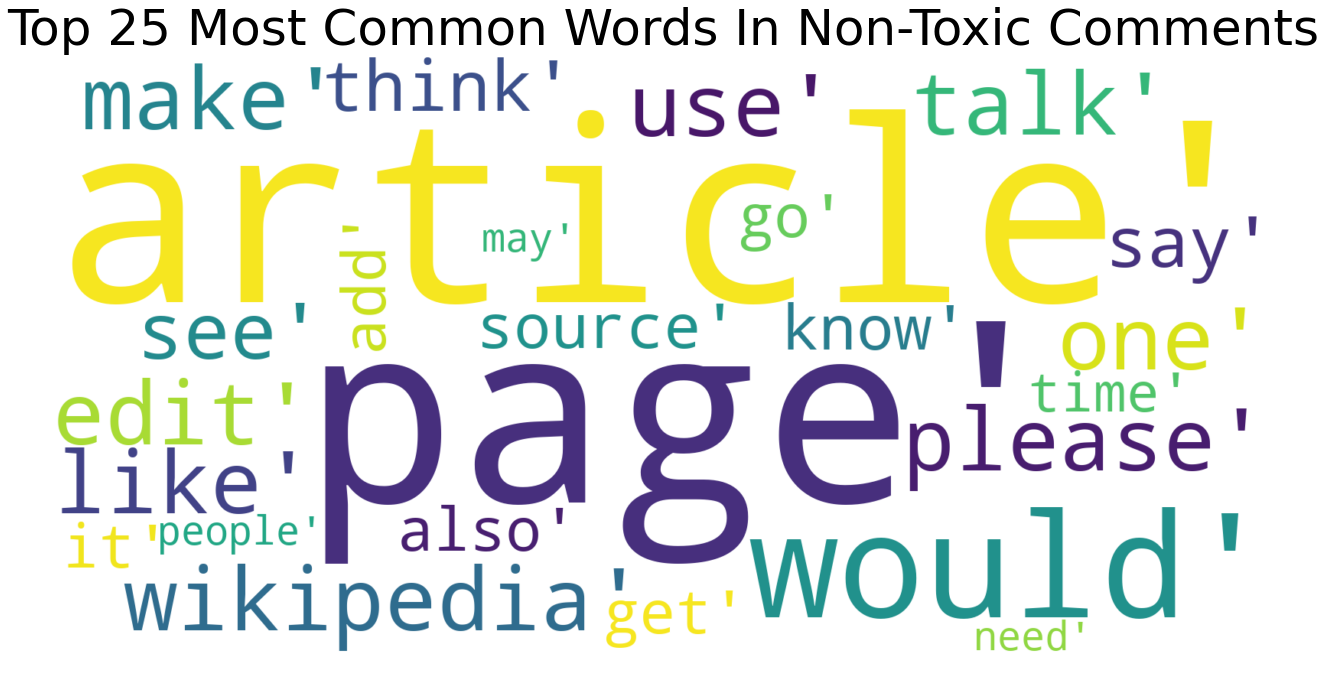

In [11]:
# посчитаем 25 самых распространенных слов для НЕтоксичных комментариев
# top 25 words for non-toxic comments

non_toxic_comm_list = clean_comments_non_toxic['comment'].astype('U').to_list()

# токенезируем НЕтоксичные твиты / tokenize non-toxic tweets
clean_comments_non_toxic_tokenized = [word_tokenize(comm) for comm in non_toxic_comm_list]

# переведем токены НЕтоксичных комментариев в один лист / non-toxic comments to a one list
all_tokens_non_toxic = []

for token_list in clean_comments_non_toxic_tokenized:
    [all_tokens_non_toxic.append(token) for token in token_list]

mostcommon_25_non_toxic = FreqDist(all_tokens_non_toxic).most_common(25)

wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon_25_non_toxic))
fig = plt.figure(figsize=(17,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 25 Most Common Words In Non-Toxic Comments', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

## Обучение моделей / Model training

### Получение тренировочной, валидационной и тестовой выборок / Split to training, test, and validation sets

Разобьем данные на обучающую, валидационную и тестовую выборки (70:15:15). Затем разделим обучающую выборку на позитивные и негативные классы, чтобы убрать дисбаланс классов.

----

Let's split the data into training, validation and test sets (70:15:15). Then we divide the training sample into positive and negative classes to remove the class imbalance.

In [12]:
features = clean_comments['comment']
target = clean_comments['toxic']

features_train, features_rem, target_train, target_rem = train_test_split(features, target, test_size=0.3, random_state=1)

features_valid, features_test, target_valid, target_test = train_test_split(features_rem, target_rem, test_size=0.5, random_state=1)

features_train_toxic = features_train[target_train == 1]
features_train_non_toxic = features_train[target_train == 0]
target_train_toxic = target_train[target_train == 1]
target_train_non_toxic = target_train[target_train == 0]

print('Размер обучающей выборки с признаками:', features_train.shape)
print('Размер обучающей выборки с целевым признаком:', target_train.shape)
print()
print('Размер валидационной выборки с признаками:', features_valid.shape)
print('Размер валидационной выборки с целевым признаком:', target_valid.shape)
print()
print('Размер тестовой выборки с признаками:', features_test.shape)
print('Размер тестовой выборки с целевым признаком:', target_test.shape)

Размер обучающей выборки с признаками: (111504,)
Размер обучающей выборки с целевым признаком: (111504,)

Размер валидационной выборки с признаками: (23894,)
Размер валидационной выборки с целевым признаком: (23894,)

Размер тестовой выборки с признаками: (23894,)
Размер тестовой выборки с целевым признаком: (23894,)


Исправим дисбаланс классов в обучающей выборке путём увеличения наблюдений с положительным классом.

Let's correct the imbalance of classes in the training sample by increasing the observations with a positive class.

In [13]:
features_train_upsampled = pd.concat([features_train_non_toxic] + [features_train_toxic] * 9)
target_train_upsampled = pd.concat([target_train_non_toxic] + [target_train_toxic] * 9)

In [14]:
print('Доля каждого из классов в тренировочном датасете ДО UPSAMPLING')
print(target_train.value_counts(normalize=True))

print()

print('Доля каждого из классов в тренировочном датасете ПОСЛЕ UPSAMPLING')
target_train_upsampled.value_counts(normalize=True)

Доля каждого из классов в тренировочном датасете ДО UPSAMPLING
0    0.898847
1    0.101153
Name: toxic, dtype: float64

Доля каждого из классов в тренировочном датасете ПОСЛЕ UPSAMPLING


1    0.503187
0    0.496813
Name: toxic, dtype: float64

Перемешаем новую тренировочную выборку.

Shuffle new training set.

In [15]:
features_train_upsampled, target_train_upsampled = shuffle(features_train_upsampled, target_train_upsampled, random_state=1)

### Логистическая регрессия / Logistic regression

Обучить модель можно только на числовых данных. Векторизируем наши комментарии. Посчитаем коэффициенты TF-IDF и обучим модель логистической регрессии.

----

The model can only be trained on numerical data. Let's vectorize our comments. Calculate the TF-IDF coefficients and train the logistic regression model.

In [16]:
count_tf_idf = TfidfVectorizer()

# делаем fit на обучающей выборке / fit on training data
tf_idf = count_tf_idf.fit(features_train_upsampled)
tf_idf_features_train = count_tf_idf.transform(features_train_upsampled)

# валидационная выборка / validation set
tf_idf_features_valid = count_tf_idf.transform(features_valid)

print(tf_idf_features_train.shape)
print(tf_idf_features_valid.shape)

(201736, 163393)
(23894, 163393)


In [17]:
# модель логистической регрессии, обученная на TF-IDF / LR model trained on TF-IDF
model_log_reg = LogisticRegression(random_state=1)

model_log_reg.fit(tf_idf_features_train, target_train_upsampled)
predictions_log_reg = model_log_reg.predict(tf_idf_features_valid)

log_reg_cv_f1 = f1_score(target_valid, predictions_log_reg)

print('F1 мера для логистической регрессии, обученной на TF-IDF (валидационная выборка):', round(log_reg_cv_f1, 2))

F1 мера для логистической регрессии, обученной на TF-IDF (валидационная выборка): 0.75


/home/uladzislau/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Неплохой результат, но не будем радоваться раньше времени, позже протестируем модель на тестовой выборке, потом будем делать выводы.

---

A good result, but we will not rejoice ahead of time, later we will test the model on a test sample, then we will draw conclusions.

### BERT

#### Подготовка данных / Data preparation

Для ускорения обучения будем использовать две тысяч записей из тренировочного датасета. Отберем их случайно. Нам необходимо перевести комментарии в вид, который от нас ожидает BERT. А именно в вектора с числами (токенами). Вектора должны содержать токены начала и конца строки ([CLS] - первый токен каждого вектора, [SEP] - помогает определеить к какому вектору принадлежит каждый из токенов, попросту это конец вектора).

Во-вторых, максимальный размер входной последовательности для BERT - 512. Если у какой-то из последовательностей размер меньше, мы применяем padding ('достраиваем' нулями), это своего рода векторизация. При токенизации в таком случае добавится элемент [PAD].

----

To speed up learning will use two thousand records from training set. I'll pick them randomly. We need to translate the comments into the form that BERT expects from us. Namely, into vectors with numbers (tokens). Vectors must contain start and end string tokens ([CLS] is the first token of each vector, [SEP] helps determine which vector each token belongs to, it's just the end of the vector).

Secondly, the maximum size of the input sequence for BERT is 512. If any of the sequences has a smaller size, we apply padding ('complete' with zeros), this is a kind of vectorization. During tokenization, in this case, the [PAD] element will be added.

In [18]:
# отберем 2000 комментариев случайно / randomly pick 2000 comments
features_train_upsampled_bert = features_train_upsampled.sample(2000)
features_train_upsampled_bert

17130                           even clean as poop nice try
96502     stupid get stupid bot wonder delete whole arti...
12680      agree disclaimer kind consensus jun utcconfusion
115065    block me see fast another post come dumbfuck w...
32378     wpfc subprojects hello termer one current acti...
                                ...                        
79201     point reporter behave time do ask tough questi...
24287     name source text article sadly link lifestyle ...
75191     true wpvain would wikipedia policy case editor...
48778     gosh need spoonfeed you well open wide see bit...
46842     inline cite notice change make footnote remove...
Name: comment, Length: 2000, dtype: object

In [19]:
# загрузим токенизатор / load tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased') # хорошо подходит для English

#применим токенизатор к нашим данным / apply tokenizer
bert_tokenized_train_features = features_train_upsampled_bert.apply(lambda x: tokenizer(x, padding='max_length', max_length=512, truncation=True, return_tensors='pt'))

bert_tokenized_train_features.head()

17130     [input_ids, token_type_ids, attention_mask]
96502     [input_ids, token_type_ids, attention_mask]
12680     [input_ids, token_type_ids, attention_mask]
115065    [input_ids, token_type_ids, attention_mask]
32378     [input_ids, token_type_ids, attention_mask]
Name: comment, dtype: object

Теперь наша переменная содержит input_ids, token_type_ids, и attention_mask для каждого из комментариев.

**input_ids**

Числовая репрезентация токенов наших комментариев.

**token_type_ids**

Бинарный признак, отражающий к какой последовательности токен относится.

**attention_mask**

Бинарный признак, отражающий какие токены в последовательности важны (1), а какие - нет (0). Например, [PAD] будет всегда 0, а остальные - 1.

Например, вот **attention_mask** для 17130-ого комментария:

---

Now our variable contains input_ids, token_type_ids, and attention_mask for each of the comments.

**input_ids**

A numerical representation of our comment tokens.

**token_type_ids**

A binary attribute that reflects which sequence the token belongs to.

**attention_mask**

A binary feature that reflects which tokens in the sequence are important (1) and which are not (0). For example, [PAD] will always be 0 and the rest will be 1.

For example, here is the **attention_mask** for the 17130th comment:

In [20]:
bert_tokenized_train_features[17130]['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0

Теперь передадим полученные данные модели BERT для получения эмбеддингов.

Now we will forward the received data to the BERT model to receive embeddings.

In [21]:
# загрузим обученную модель Bert / load Bert
model_bert = transformers.BertModel.from_pretrained('bert-base-cased')

# будем использовать батчи / apply batches
batch_size = 100
embeddings = []
for i in tqdm(range(bert_tokenized_train_features.shape[0] // batch_size)):
  batch = bert_tokenized_train_features[batch_size*i:batch_size*(i+1)] 
  for token in batch:
    with torch.no_grad():
      embed = model_bert(token['input_ids'], attention_mask=token['attention_mask'])
        
    embeddings.append(embed[0][:,0,:].numpy())

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████| 20/20 [09:22<00:00, 28.11s/it]


С помощью нейронной сети **BERT** мы получили эмбеденги наших комментариев. Теперь обучим логистическую регрессию (ЛР) на этих эмбедингах и сравним ее с ЛР, обученной на TF-IDF.

In [23]:
# создадим фичи и таргет из эмбедингов / create features and target from embeddings
features_emb = np.concatenate(embeddings)

idxs_bert = features_train_upsampled_bert.index
target_emb = comments.loc[idxs_bert]['toxic']

# разделим наборы на тестовый, тренировочный, и валидационный/ split to train/test/validation sets
features_train_emb, features_rem_emb, target_train_emb, target_rem_emb = train_test_split(features_emb, target_emb, test_size=0.4, random_state=1)

features_valid_emb, features_test_emb, target_valid_emb, target_test_emb = train_test_split(features_rem_emb, target_rem_emb, test_size=0.5, random_state=1)

print(features_train_emb.shape)
print(target_train_emb.shape)
print(features_valid_emb.shape)
print(target_valid_emb.shape)
print(features_test_emb.shape)
print(target_test_emb.shape)

(1200, 768)
(1200,)
(400, 768)
(400,)
(400, 768)
(400,)


In [25]:
model_lr_emb = LogisticRegression()
model_lr_emb.fit(features_train_emb, target_train_emb)

predictions_emb_val = model_lr_emb.predict(features_valid_emb)

log_reg_emb_f1_val = f1_score(target_valid_emb, predictions_emb_val)

print('F1 мера для логистической регрессии, обученной на эмбедингах (валидационная выборка):', round(log_reg_emb_f1_val, 2))

F1 мера для логистической регрессии, обученной на эмбедингах (валидационная выборка): 0.82


/home/uladzislau/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Логистическая регрессия, обученная на эмбедингах **BERT** показала F1-score равный 0.82, что значительно выше, чем ЛР, обученная на TF-IDF.

--------

Logistics regression trained on BERT embeddings showed F1-score on validation set of 0.82. It is greater than in LR trained on TF-IDF.

## Проверка BERT на тестовой выборке / BERT model check on test data

Для проверки на тестовой выборке выбрали логистическую регрессию, обученную на эмбедингах **BERT**.

We selected logistic regression trained on embeddings from BERT for testing on test dataset.

In [26]:
test_predictions_emb = model_lr_emb.predict(features_test_emb)

f1_score_log_reg_test_emb = f1_score(target_test_emb, test_predictions_emb)

print('F1 мера для логистической регрессии на тестовых данных:', round(f1_score_log_reg_test_emb, 2))

F1 мера для логистической регрессии на тестовых данных: 0.85


## Выводы / Conclusions

В данном сложном проекте мы работали с текстовыми данными - комментариями с сайта магазина "Викишоп".

Данные были подготовлены и изучены. В целевой переменной был найден дисбаланс класов, который устранили методом **upsampling**. В качесвте подготовки данных выполнили приведение всех комментариев к нижнему регистру, удалили стоп-слова, ссылки и html-тэги. Также была проведена работа по конверсии слэнговых сокращений к их полной форме. В комментариях были изучены эмотиконы и смайлы и также переведены в текстовую форму. Была удалена пунктуация, небуквенные и не латинские символы. Очищенные комментарии были лемматизированы.

Далее был проведен исследовательский анализ комментариев. Для этого лемматизированные комментариий были токенезированы. Были найдены 100 самых распространенных слов. С помощью облака слов мы исследовали топ 25 самых распространенных слов в токсичных и нетоксичных комментариях. Среди них в токсичных комментариях были нецензурные и оскорбительные слова, вто время как среди нетоксичных комментариев преобладали слова нейтральной окраски.

Мы обучили две модели логистической регрессии. Одну на признаках TF-IDF, другую - на эмбедингах **BERT**. Обе модели были проверены на валидационной выборке, а затем на тестовой. Логистическая регрессия, обученная на эмбедингах показала лучший результат на валидационной выборке (F1-score 0.82 vs 0.75) и была выбрана для проверки на тестовых данных.

Логистическая регрессия, обученная на эмбедингах показала F1-score равный 0.85 на тестовых данных, что превышает установленный заказчиком порог.

------

In this complex project, we worked with text data - comments from the website of the Wikishop store.

The data was prepared and studied. An imbalance of classes was found in the target variable, which was eliminated by the **upsampling** method. As a data preparation, all comments were reduced to lower case, stop words, links and html tags were removed. Work was also carried out to convert slang abbreviations to their full form. Emoticons and emoticons were studied in the comments and also translated into text form. Punctuation, non-alphabetic and non-Latin characters have been removed. Cleaned up comments have been lemmatized.

An exploratory analysis of the comments was then carried out. To do this, lemmatized comments have been tokenized. The 100 most common words were found. Using the word cloud, we explored the top 25 most common words in toxic and non-toxic comments. Among them, toxic comments included obscene and offensive words, while non-toxic comments were dominated by neutral words.

We trained two logistic regression models. One on TF-IDF features, the other on **BERT** embeddings. Both models were tested on the validation set and then on the test set. Logistic regression trained on embeddings showed the best result on the validation set (F1-score 0.82 vs 0.75) and was chosen for testing on test data.

Logistic regression trained on embeddings showed an F1-score of 0.85 on test data, which exceeds the threshold set by the customer.